# Как проводится очистка данных от выбросов
> Осинкин Александр 10И3

## План:
- Математические методы
- Графические методы
- Методы на основе кластеризации
- Технические ошибки
- Логические методы
---

In [ ]:
import datetime
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
sns.set_theme(context='talk', style='whitegrid', palette='deep')
plt.rcParams['figure.figsize'] = 10, 7
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['figure.titlesize'] = 32
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['figure.autolayout'] = 'true'
plt.rcParams['figure.frameon'] = 'false'
plt.rcParams['axes.spines.left'] = 'false'
plt.rcParams['axes.spines.right'] = 'false'
plt.rcParams['axes.spines.top'] = 'false'
plt.rcParams['legend.fancybox'] = 'false'
plt.rcParams['axes.spines.bottom'] = 'false'
plt.rcParams['font.size'] = 20
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# для графиков, где надо много цветов, юзайте воть:
sns.set_palette(sns.color_palette('deep'))
# а по дефолту воть:
sns.set_palette(sns.color_palette('BuGn_r', n_colors=10)[2::3])
pd.set_option('display.max_columns', 60)

In [44]:
df = sns.load_dataset("diamonds")
df.sample(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
20500,1.71,Good,J,VS2,62.8,58.0,8831,7.48,7.55,4.72
48028,0.74,Very Good,J,SI2,59.1,58.0,1923,5.93,5.99,3.52
20366,1.28,Ideal,H,VVS1,61.7,55.0,8759,6.97,7.01,4.31
39437,0.41,Ideal,D,VS2,62.8,55.0,1076,4.73,4.70,2.96
52414,0.70,Premium,G,VS1,61.4,59.0,2512,5.59,5.74,3.51


### Математические методы

1. **Самый распространённый метод для выявления выбросов: метод межквартильного размаха ($IQR$)**
    - Принцип работы:
        - Вычисляются 1-й и 3-й квартили (далее -- $Q1$ и $Q3$)
        - Вычисляется межквартильный размах ($IQR$):
            $$
            IQR = Q3 - Q1
            $$
        - Выбросами считаются те значения, которые лежат ниже $Q1 - k \cdot IQR$ или выше $Q3 + k \cdot IQR$, где $k$ -- какой-то коэффициент, обычно 1.5
    - Плюсы:
        - Простота имплементации
        - Не зависит от домена (применим к любым типам данных)
    - Минусы:
        - Устаревший подход -- часто неэффективен для современных точных данных. Например, в биологической сфере данные могут иметь сложную структуру, и очистка данных по $IQR$ может привести к сильным смещениям
        - Не зависит от домена -- из-за этого даже адекватные значения могут быть определены как выбросы
    - Этот метод также используется при визуализации ящиков с усами (boxplot)
    - Мини-мини-итог: метод редко используется в современных реалиях из-за своих существенных минусов

2. **Метод стандартных отклонений**

    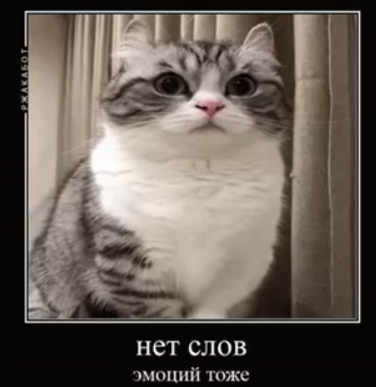

    - Принцип работы:
        - Для каждого значения данных вычисляется его отклонение от среднего значения
        - Если это отклонение больше или меньше определённого порога (чаще всего 2 или 3 стандартных отклонений), то значение считается выбросом
    - Плюсы и минусы в точности повторяют 1-й метод, но присутствует ещё один минус -- предпосылка о нормальном распределении, что очень редко встречается в реальных данных

3. **Метод ближайших соседей (kNN)**
    - Принцип работы:
        - Выбирается гиперпараметр -- $k$
        - Для каждого наблюдения считается сумма расстояний между точкой и $k$ ближайшими наблюдениями по выбранной метрике расстояния (например, евклидова или манхэттенская, в зависимости от постановки задачи) по необходимым признакам (features)
        - Выбирается порог максимального расстояния для 3 соседей (threshold)
        - Очищаются все наблюдения, расстояния которых больше порога (threshold)
    - Плюсы:
        - Работа с многомерными данными
    - Минусы:
        - Необходимо подбирать гиперпараметр $k$
        - Необходимо выбирать threshold
    - Мини-мини-итог: метод редко используется в современных реалиях из-за большого количества подбора параметров.
> Мини-итог: В математических методах не нашлось адекватных способов искать выбросы
---

## Графические методы
1. **Ящик с усами (boxplot)**

    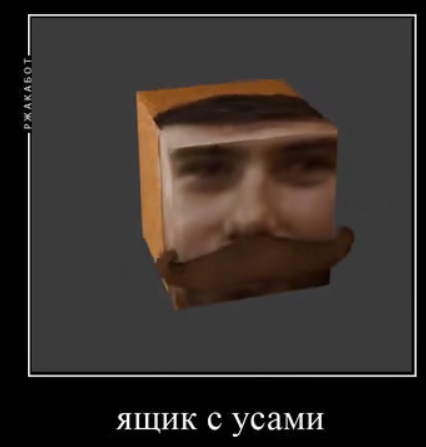

    - Принцип работы:
        - Построить boxplot
        - Определить выбросы
        - По факту то же самое, что и межквартильный размах, но определяется графически
    - Плюсы и минусы идентичны с 1 математическим методом, иногда можно более четко определить из за графического отображения

<Axes: xlabel='depth'>

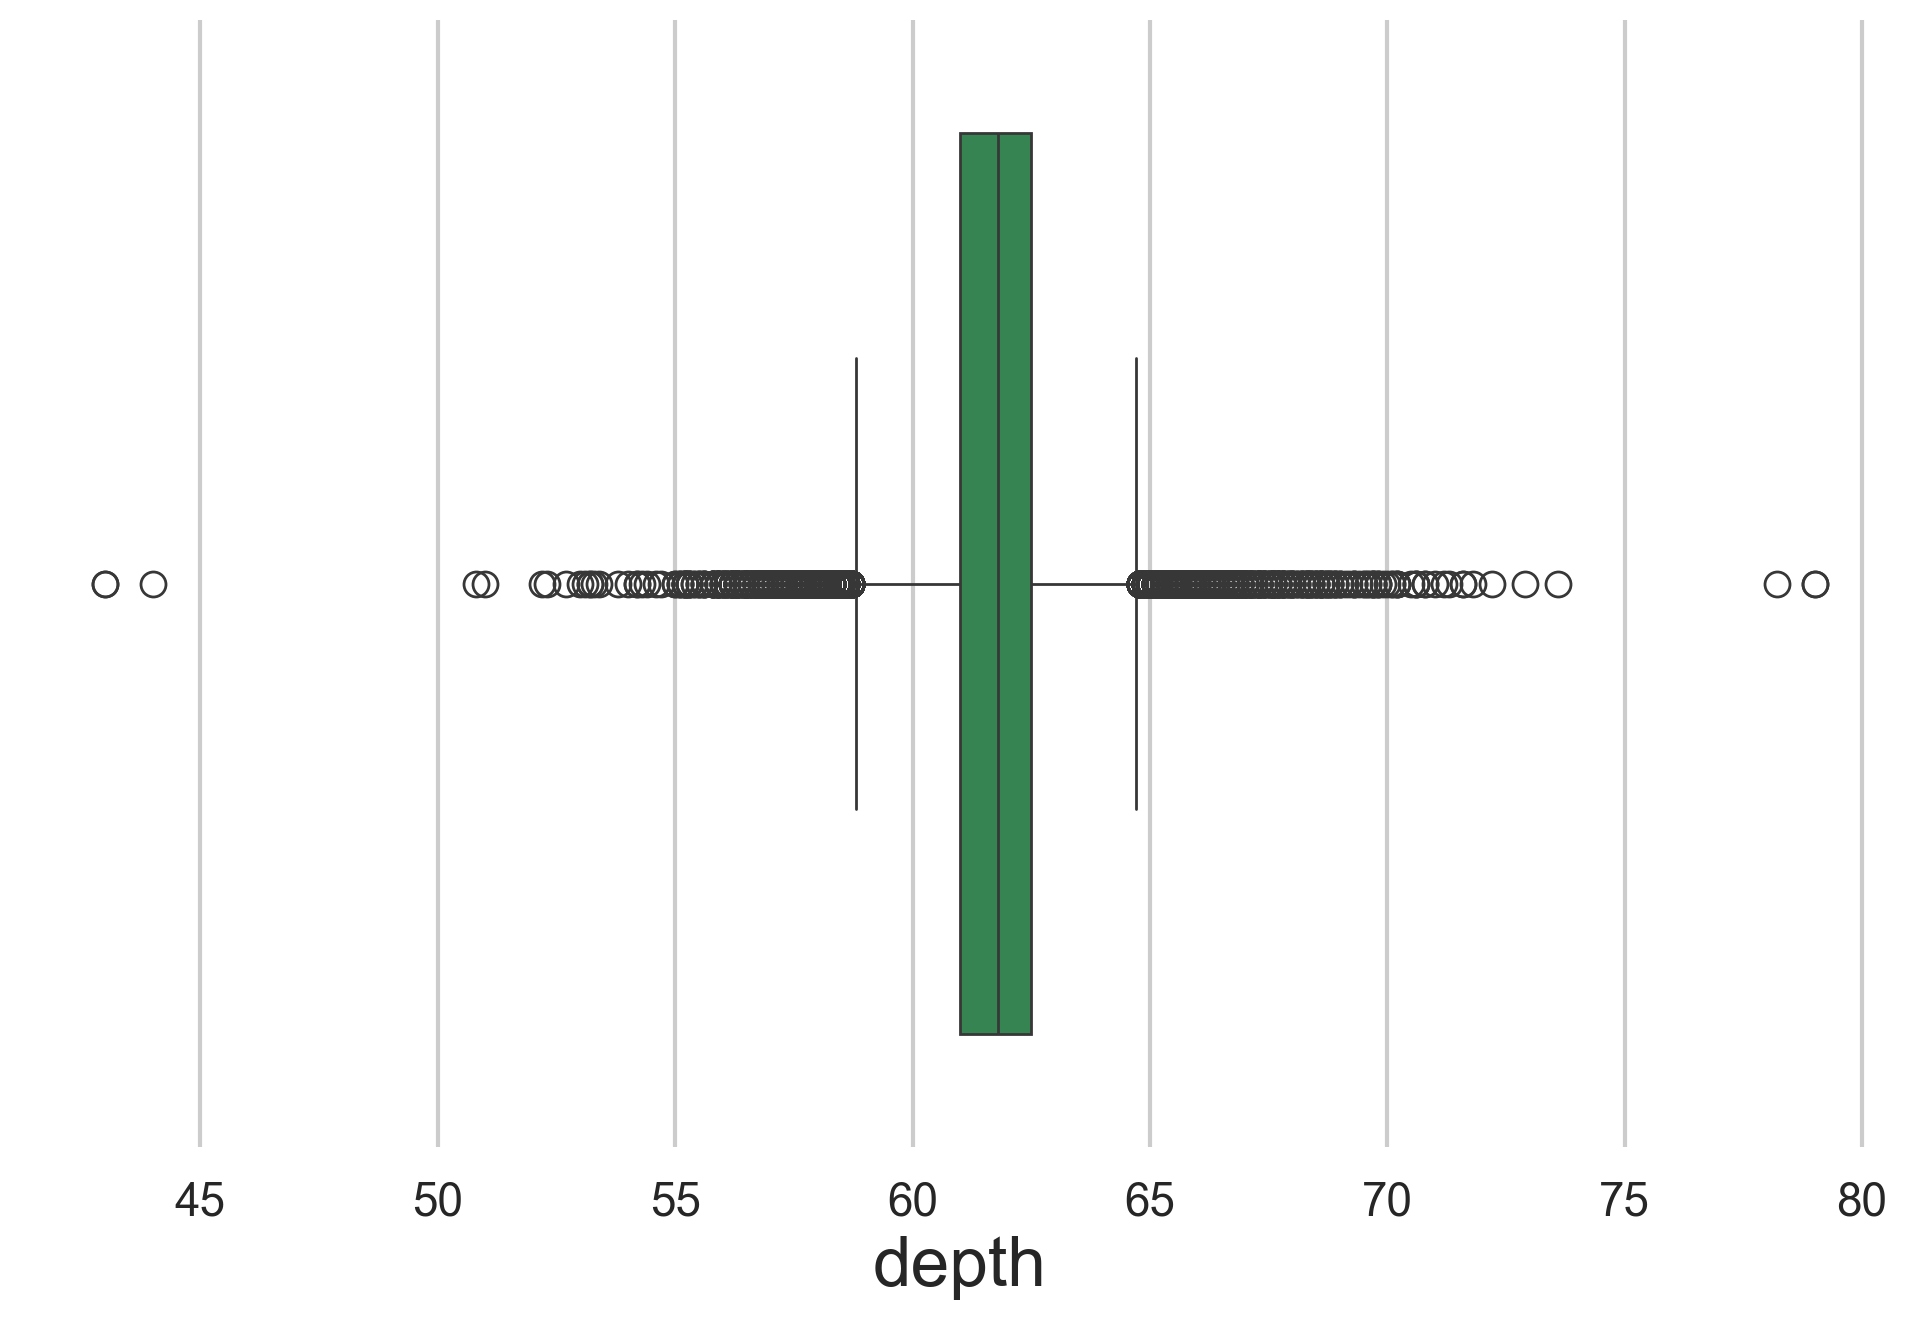

In [26]:
sns.boxplot(df, x="depth")

2. **boxenplot**

    - Существует альтернатива boxplot $\rightarrow$ boxenplot
    - Он лучше отображает выбросы в современных реалиях
    - Он отображает ящиками множество квантилей, а точками -- выбросы
    - Плюсы:
        - Помогает понизить вероятность FP(False-Positive(Ложно положительной)) ошибки -- основная проблема boxplot

<Axes: xlabel='depth'>

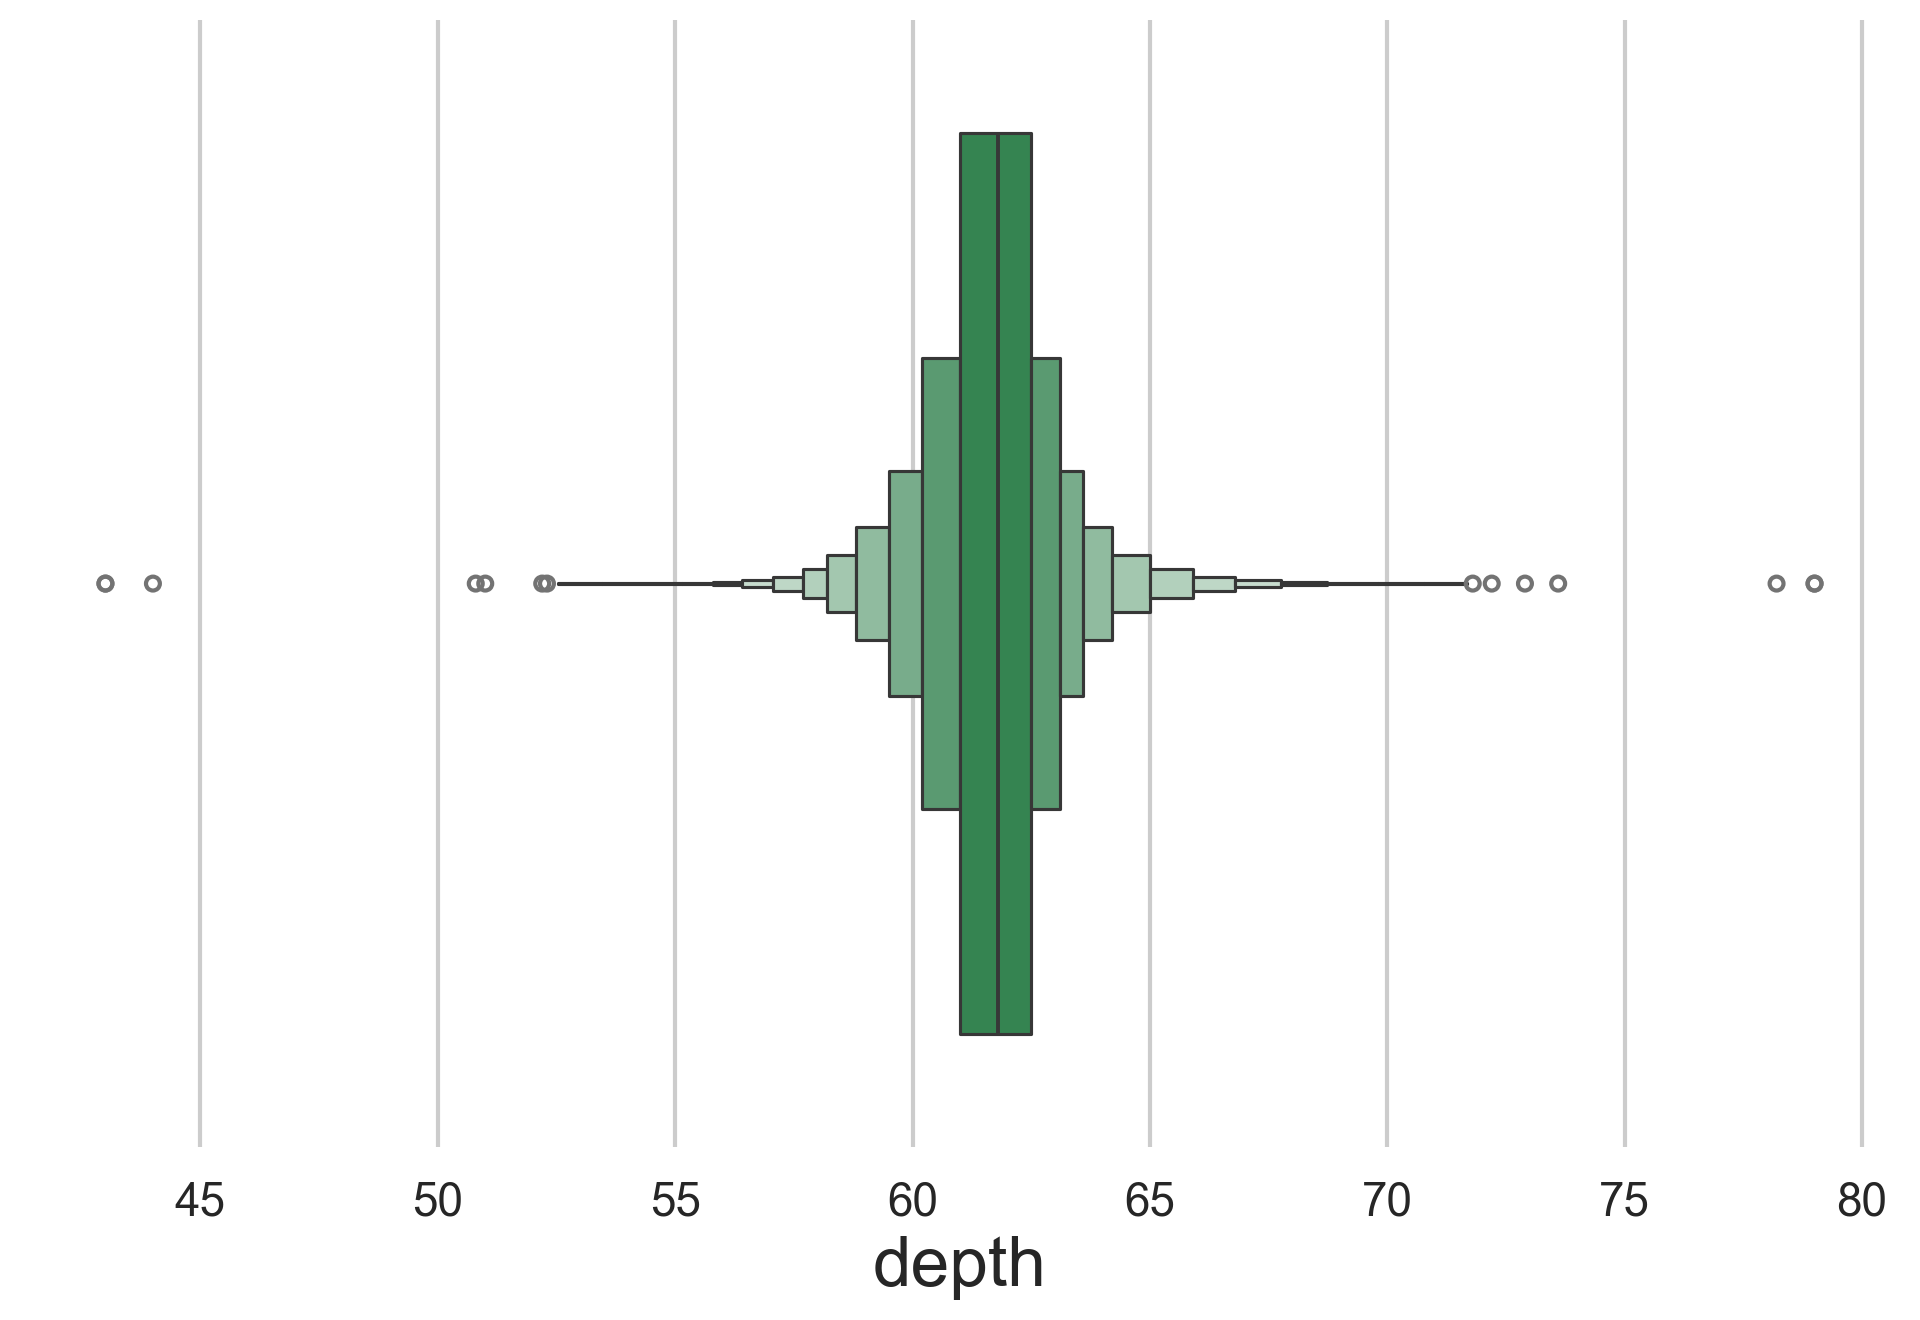

In [36]:
sns.boxenplot(df, x="depth")

3. **Распределение переменной**
    - Принцип работы:
        - Построить гистограмму(histplot)
        - Подумать, предположить какие наблюдения не принадлежат генеральной совокупности(далее -- ГС), которую мы анализируем
    - Плюсы:
        - Можно определить выбросы четче, чем в предыдущих вариантах
    - Минусы:
        - Невозможно валидировать границу, при которой данные не принадлежат ГС

<Axes: xlabel='depth', ylabel='Count'>

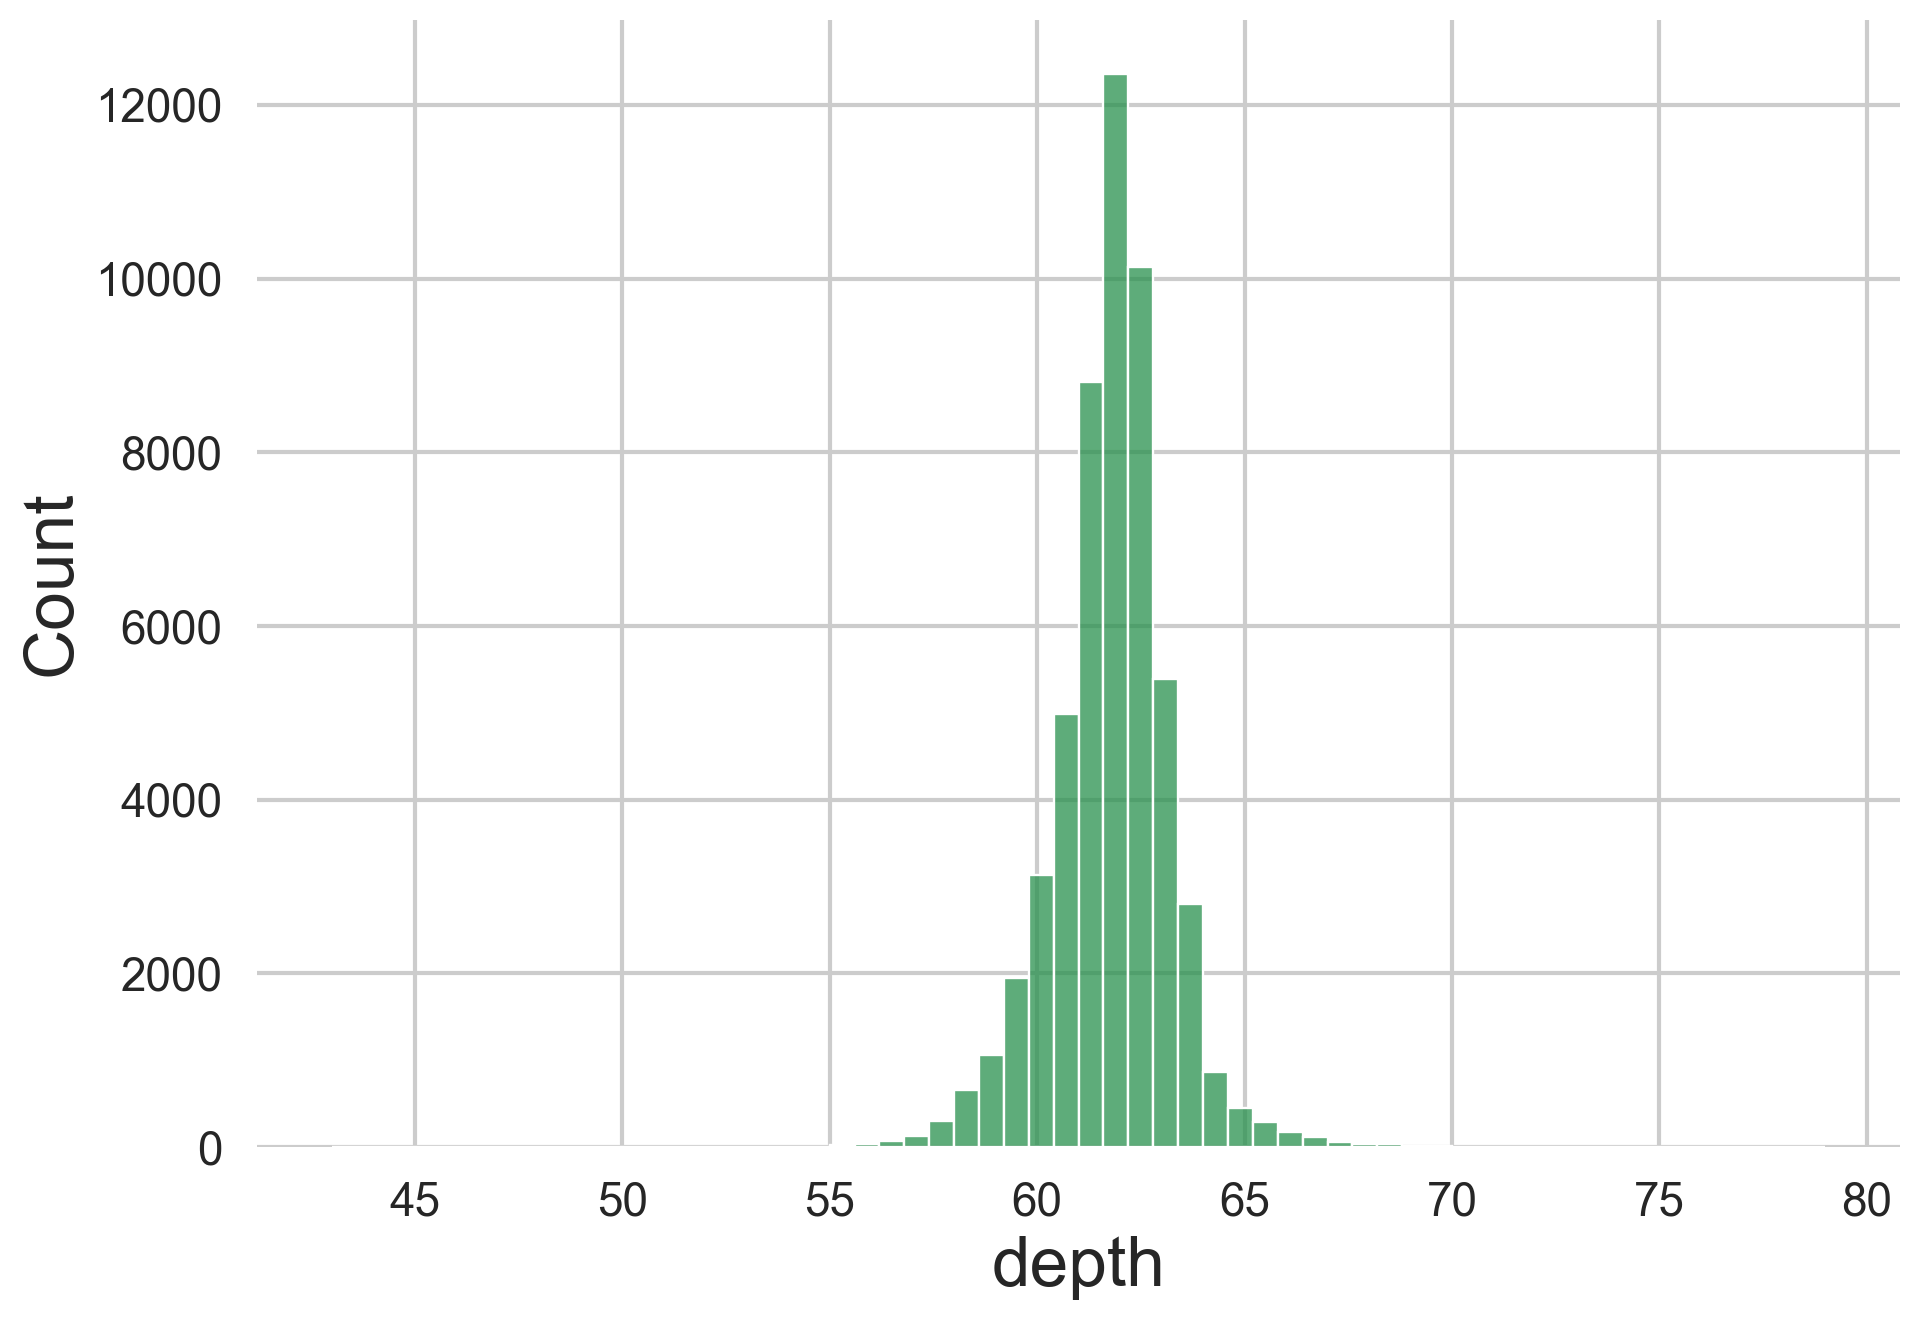

In [34]:
sns.histplot(df, x="depth", bins=60)

4. **Диограмма рассеяния (scatterplot)**
    - Принцип работы:
        - Построить диограмму рассеяния(scatterplot)
        - Подумать, предположить какие наблюдения не принадлежат ГС, которую мы анализируем
    - Плюсы:
        - Может помочь при работе с двумерными данными
    - Минусы:
        - Необходимо понимать какие совокупности данных не могут принадлежать ГС

<Axes: xlabel='depth', ylabel='carat'>

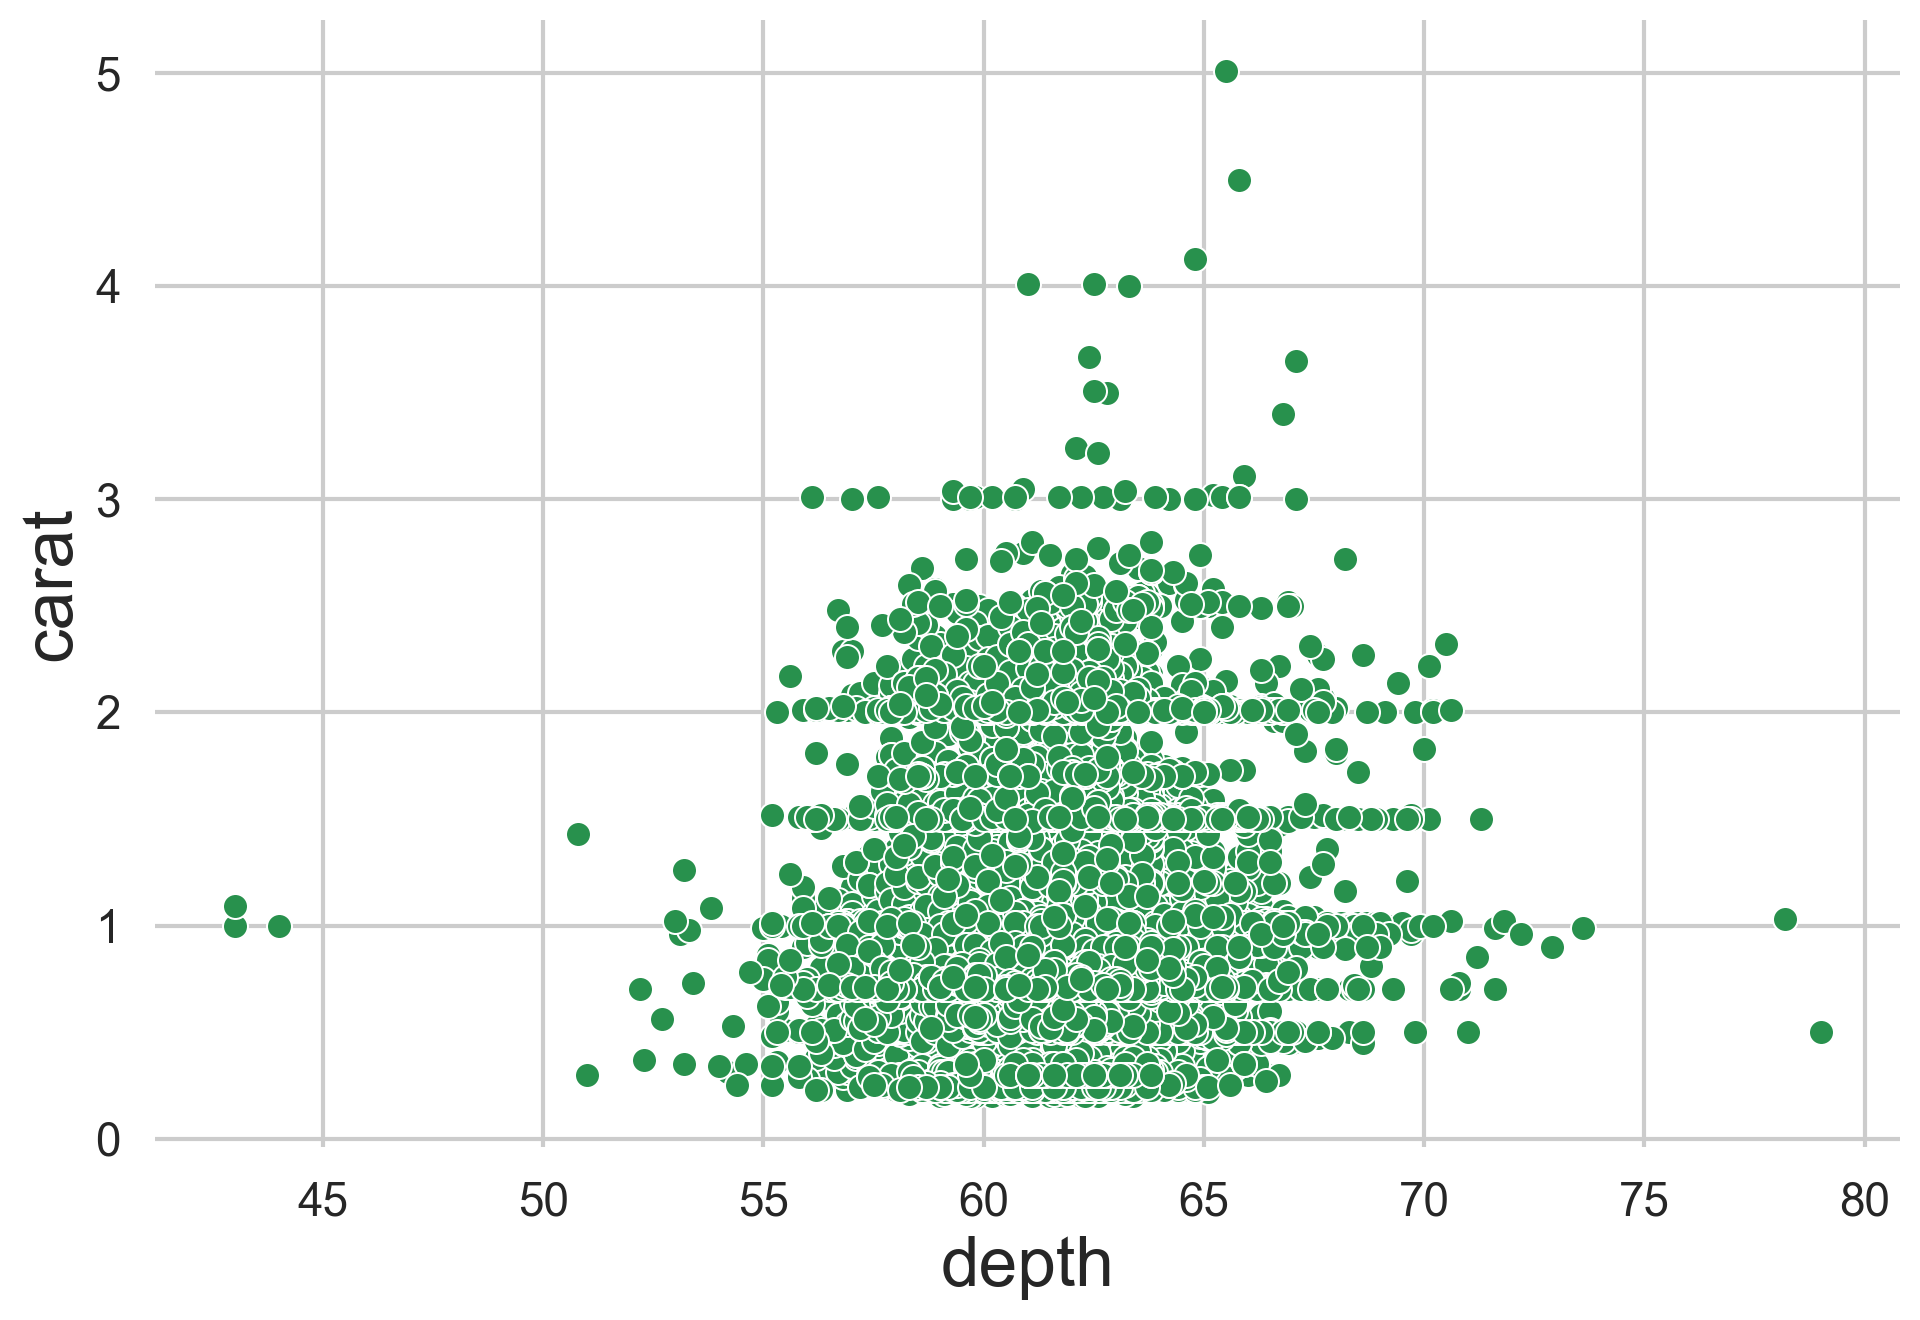

In [35]:
sns.scatterplot(df, x="depth", y="carat")

> Мини-итог: Графические методы лучше помогают понять какие из наблюдений выбросы, но нет четкой валидации границы
---

## Методы на основе кластеризации
1. **DBSCAN**
    - Принцип работы
        - DBSCAN -- это алгоритм кластеризации на основе плотности
        - Во время кластеризации он выделяет отдельный класс -- шум/выбросы
    - Плюсы:
        - Простое применение
        - Работа с множеством признаков(features)
    - Минусы:
        - Требуются гиперпараметры: eps -- радиус окрестности для поиска соседей и minPts -- минимальное количество точек для формирования кластера
        - Нормально работает только с одинаковой плотностью кластеров
2. **HDBSCAN**
    - Принцип работы
        - HDBSCAN -- улучшение DBSCAN
        - Сам подбирает eps для каждого кластера
    - Плюсы:
        - Применение еще проще
        - Работа с множеством признаков(features)
    - Минусы:
        - Требует гиперпараметр min_samples -- чувствительность к шуму, что тоже не приятно, но лучше фиксированного eps для всех кластеров
> Мини-итог: Алгоритмы кластеризации неплохи для определения выбросов, часто используются конкретно при задаче кластеризации
---

## Технические ошибки

- Технические ошибки часто возникают из-за неправильного сбора данных
- Принцип работы:
    - Изучить домен
    - Понять, какие данные технически невозможны
    - Очистить датасет от таких данных
- Примеры:
    - Вероятность события не в пределах от 0 до 1
    - Несуществующие измерения, например, карат
    - Цена товара меньше 0
- Плюсы:
    - Идеально определяют выбросы при чётком знании домена
- Минусы:
    - Необходимо знание домена
> Мини-итог: Часто применяются, идеально определяют выбросы
---

## Логические методы
- Основаны на очень высоком уровне знания домена, это не просто ошибки, а именно данные не принадлежащие ГС, определенные по знанию домена
- Пример:
    - Существует ферма, в которой отличается процесс получения молока(дойки), из за этого все показатели фермы занижены, что возможно определить только при полном понимании домена
- Плюсы:
    - Идеально определяют выбросы при чётком знании домена
- Минусы: 
    - Необходимо доскональное изучение домена
    - Такие знания тяжело получаются, часто только с помощью контактирования с создателями датасета/работниками компании
> Мини-итог: Всегда полезны, но из за тяжелого получения такого досканального знания домена применяется реже других
---

## Итог 
1. Математические методы -- часто не четкие
2. Графические методы -- более четкие, но без возможности провалидировать порог
3. Методы на основе кластеризации -- Используются при задаче кластеризации
4. Технические ошибки -- Идеальное определение выбросов
5. Логические методы -- Идеальное определение выбросов, но требеют знание домена
> Чаще всего применяют **4-й** и **5-й** методы в совокупности. Это позволяет точно очистить данные от выбросов, не создавая смещения от ошибок очистки.
---

## Источники:
### Статьи:
- [Обнаружение выбросов математически и графически](https://loginom.ru/blog/outliers)
- [DBSCAN](https://habr.com/ru/articles/322034/)
- [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html)
### Исследования:
- "A Survey of Outlier Detection Methodologies" (Chandola et al., 2009) -- Описывает различные математические методы обнаружения выбросов, включая kNN

> А так же сказания Пильноватых Глеба, и опыт работы с проектом